## Домашнее задание «Обучение сверточной сети на практике»

### Задание: *Классификация изображений: Cats vs Dogs*

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. 
Шаблон ipython-ноутбука для решения можно скачать по <a href="https://github.com/a4tunado/lectures/tree/master/006" target="_blank"> ссылке</a>. 
Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
<a href="https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition" target="_blank"> Датасет </a>.

## Решение

### Загружаем необходимые библиотеки

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())


2.15.0
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('dogs-vs-cats_data/train/*.jpg')
test_files = glob('dogs-vs-cats_data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

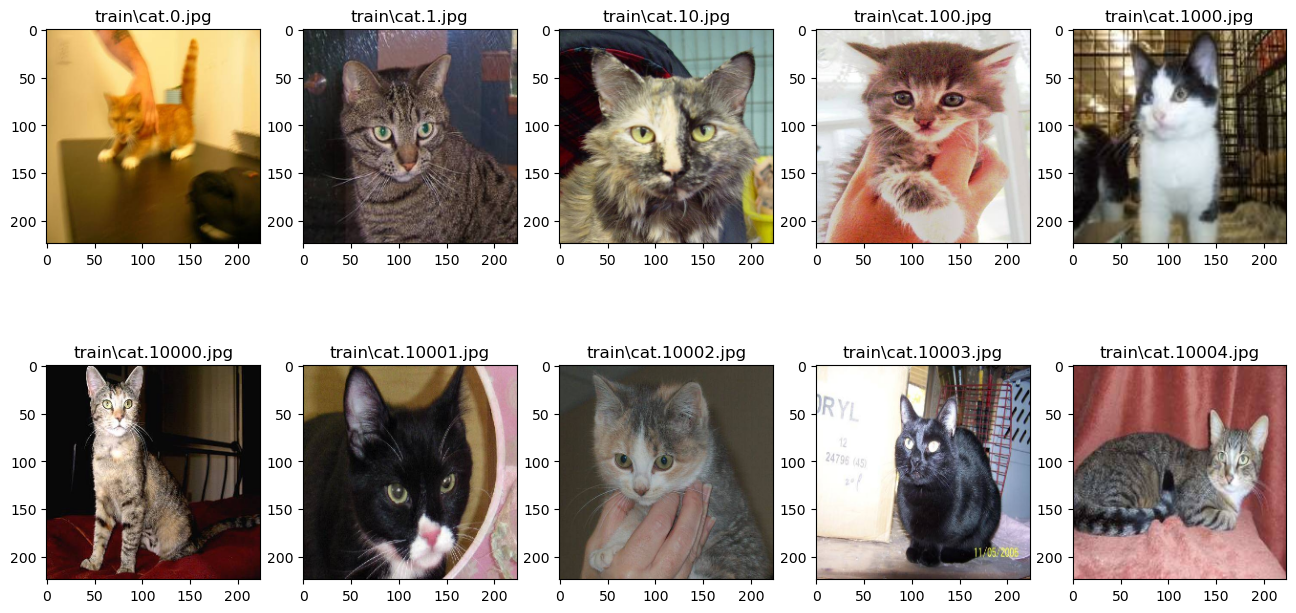

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)



In [7]:
model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [9]:
model.summary()


Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [10]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-8)

In [11]:
model.compile(optimizer = opt_adam, 
              loss = 'binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics = ['accuracy'])

In [12]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [13]:
# Этот callback (ReduceLROnPlateau) уменьшает скорость обучения, когда метрика (val_loss) перестала улучшаться.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', # отслеживание потери на валидационном наборе данных
                                                 patience = 5, # количество эпох без улучшения, после которых будет применено уменьшение скорости обучения.
                                                 min_delta = 1e-7, # минимальное изменение в функции потерь, которое считается значительным.
                                                 verbose = 2, # уровень подробности вывода информации о событиях.
                                                 factor = .5, #  коэффициент уменьшения скорости обучения
                                                 min_lr = 1e-10, # минимальная допустимая скорость обучения.
                                                 mode = 'auto') # автоматический режим для определения лучшего значения функции потерь 6.

# Этот callback (EarlyStopping) останавливает обучение, если функция потерь не улучшается в течение заданного количества эпох.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  min_delta = 1e-7,
                                                  patience = 5,
                                                  verbose = 2,
                                                  mode = 'auto',
                                                  restore_best_weights = False) # не восстанавливать веса модели, которые давали наилучший результат.

# Этот callback (ModelCheckpoint) сохраняет модель или веса модели во время обучения. Параметры включают:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.keras', # путь к файлу для сохранения модели или весов.
                                                      monitor = 'val_loss', 
                                                      verbose = 1,
                                                      save_best_only = True, # сохранять только лучшую модель
                                                      save_weights_only = True, # сохранять только веса модели, а не всю структуру модели
                                                      mode = 'min') # режим, в котором "лучшее" значение функции потерь определяется как минимальное значение

In [14]:
# val_samples = 100  # число изображений в валидационной выборке

# shuffle(train_files)  # перемешиваем обучающую выборку
# validation_data = next(fit_generator(train_files[:val_samples], val_samples))
# train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

In [15]:
shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)  # данные читаем функцией-генератором

In [15]:
# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=100,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data,
          callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/100


100/100 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6837 
Epoch 1: val_loss improved from inf to 0.45943, saving model to my_model.keras
100/100 [==============================] - 1058s 11s/step - loss: 0.6513 - accuracy: 0.6837 - val_loss: 0.4594 - val_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.8030
Epoch 2: val_loss improved from 0.45943 to 0.33467, saving model to my_model.keras
100/100 [==============================] - 1005s 10s/step - loss: 0.4614 - accuracy: 0.8030 - val_loss: 0.3347 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8469 
Epoch 3: val_loss improved from 0.33467 to 0.28078, saving model to my_model.keras
100/100 [==============================] - 1025s 10s/step - loss: 0.3853 - accuracy: 0.8469 - val_loss: 0.2808 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 4

KeyboardInterrupt: 

In [ ]:
# Обучение длилось 10 часов на нутбуке huawei 16 Гб оперативки. Пришлось прервать и использовать модель которая обучалась в итоге на 38 эпохах.

In [17]:
model.load_weights('my_model.keras')

In [18]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Предсказания на проверочной выборке

In [19]:
test_pred = model.predict(predict_generator(test_files),
                          steps=len(test_files))

12500/12500 [==============================] - 1673s 134ms/step


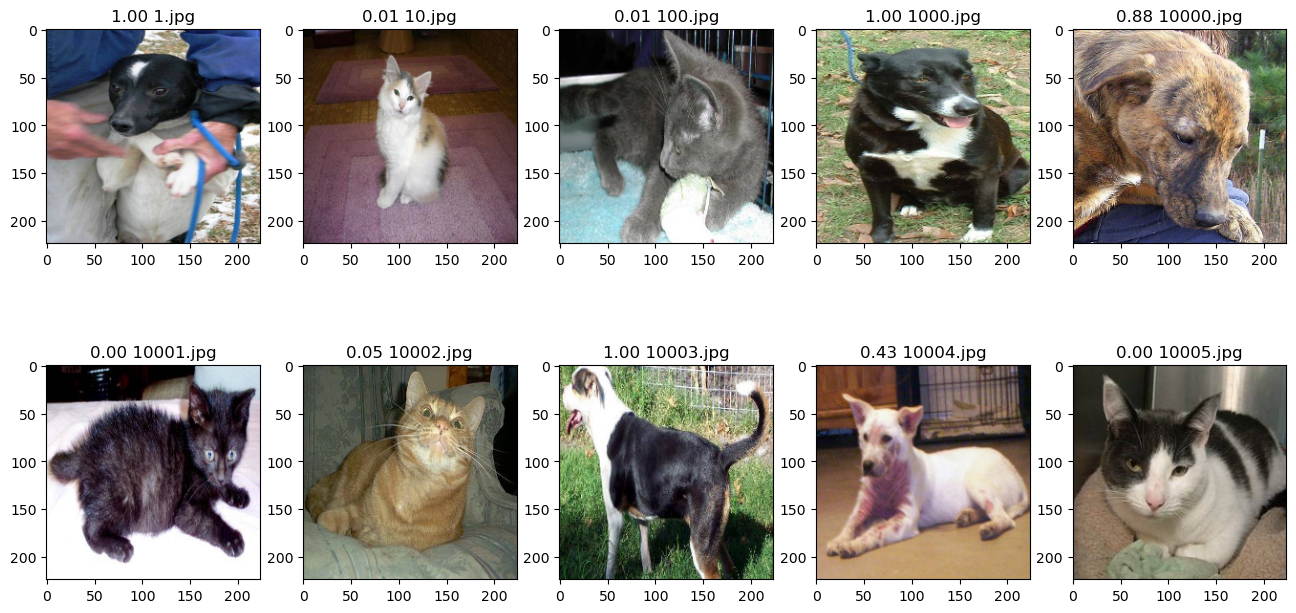

In [20]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [21]:
import re

with open('submit_vgg16.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

 ![score](submit_SCV_result.png)
